In [1]:
# imports

from PIL import Image
from glob import glob
import pandas as pd
import skimage, os
from skimage.morphology import ball, disk, dilation, binary_erosion, remove_small_objects, erosion, closing, reconstruction, binary_closing
from skimage.measure import label,regionprops, perimeter
from skimage.morphology import binary_dilation, binary_opening, convex_hull_image
from skimage.filters import roberts, sobel
from skimage import measure, feature
from skimage.segmentation import clear_border
from skimage import data
from scipy import ndimage as ndi
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
import pydicom
import scipy.misc
import numpy as np
import SimpleITK as sitk
from matplotlib import pyplot as plt

luna_path = '/vol/bitbucket/xz1919/Imperial-Individual-Project/processed_data_raw/'
luna_subset_path = '/vol/bitbucket/xz1919/Imperial-Individual-Project/processed_data_raw/lungs_roi/'
file_list=glob(luna_subset_path+"*.npy")

In [18]:
def get_segmented_lungs(im, plot=False):
    '''
    This funtion segments the lungs from the given 2D slice.
    '''
    plt_number = 0
    # Original image label: 0
    if plot:
        f, plots = plt.subplots(12, 1, figsize=(5, 40))
        plots[plt_number].axis('off')
        plots[plt_number].set_title(f'{plt_number}')
        plots[plt_number].imshow(im, cmap=plt.cm.bone)
        plt_number += 1

    # Step 1: Convert into a binary image.
    # image label: 1
    binary = im < -604
    if plot:
        plots[plt_number].axis('off')
        plots[plt_number].set_title(f'{plt_number}')
        plots[plt_number].imshow(binary, cmap=plt.cm.bone)
        plt_number += 1
    # Step 2: Remove the blobs connected to the border of the image.
    # image label: 2
    cleared = clear_border(binary)
    if plot:
        plots[plt_number].axis('off')
        plots[plt_number].set_title(f'{plt_number}')
        plots[plt_number].imshow(cleared, cmap=plt.cm.bone)
        plt_number += 1
    # Step 3: Label the image.
    # image label: 3
    label_image = label(cleared)
    if plot:
        plots[plt_number].axis('off')
        plots[plt_number].set_title(f'{plt_number}')
        plots[plt_number].imshow(label_image, cmap=plt.cm.bone)
        plt_number += 1
        
    label_image_save = label_image.copy()

    # Step 4: Keep the labels with 2 largest areas and segment two lungs.
    # image label: 4
    areas = [r.area for r in regionprops(label_image)]
    areas.sort()
    labels = []
    if len(areas) > 2:
        for region in regionprops(label_image):
            if region.area < areas[-2]:
                for coordinates in region.coords:
                    label_image[coordinates[0], coordinates[1]] = 0
            else:
                coordinates = region.coords[0]
                labels.append(label_image[coordinates[0], coordinates[1]])
    else:
        labels = [1, 2]
    if plot:
        plots[plt_number].axis('off')
        plots[plt_number].set_title(f'{plt_number}')
        plots[plt_number].imshow(label_image, cmap=plt.cm.bone)
        plt_number += 1
    # Step 5: Fill in the small holes inside the mask of lungs which we seperate right and left lung. r and l are symbolic and they can be actually left and right!
    # image labels: 5, 6
    r = label_image == labels[0]
    l = label_image == labels[1]
    r_edges = roberts(r)
    l_edges = roberts(l)
    r = ndi.binary_fill_holes(r_edges)
    l = ndi.binary_fill_holes(l_edges)
    if plot:
        plots[plt_number].axis('off')
        plots[plt_number].set_title(f'{plt_number}')
        plots[plt_number].imshow(r, cmap=plt.cm.bone)
        plt_number += 1

        plots[plt_number].axis('off')
        plots[plt_number].set_title(f'{plt_number}')
        plots[plt_number].imshow(l, cmap=plt.cm.bone)
        plt_number += 1

    # Step 6: convex hull of each lung
    # image labels: 7, 8
    r = convex_hull_image(r)
    l = convex_hull_image(l)
    if plot:
        plots[plt_number].axis('off')
        plots[plt_number].set_title(f'{plt_number}')
        plots[plt_number].imshow(r, cmap=plt.cm.bone)
        plt_number += 1

        plots[plt_number].axis('off')
        plots[plt_number].set_title(f'{plt_number}')
        plots[plt_number].imshow(l, cmap=plt.cm.bone)
        plt_number += 1
    # Step 7: joint two separated right and left lungs.
    # image label: 9
    sum_of_lr = r + l
    binary = sum_of_lr > 0
    if plot:
        plots[plt_number].axis('off')
        plots[plt_number].set_title(f'{plt_number}')
        plots[plt_number].imshow(binary, cmap=plt.cm.bone)
        plt_number += 1
    # Step 8: Closure operation with a disk of radius 10. This operation is
    # to keep nodules attached to the lung wall.
    # image label: 10
    selem = disk(10)
    binary = binary_closing(binary, selem)
    if plot:
        plots[plt_number].axis('off')
        plots[plt_number].set_title(f'{plt_number}')
        plots[plt_number].imshow(binary, cmap=plt.cm.bone)
        plt_number += 1
    # Step 9: Superimpose the binary mask on the input image.
    # image label: 11
    get_high_vals = binary == 0
    im[get_high_vals] = 0
    if plot:
        plots[plt_number].axis('off')
        plots[plt_number].set_title(f'{plt_number}')
        plots[plt_number].imshow(im, cmap=plt.cm.bone)
        plt_number += 1

    return im, label_image, binary, label_image_save

In [19]:
imgs = []
for file in file_list:
    imgs.append((np.load(file), file))

img_tuple = [(get_segmented_lungs(im), filename) for im, filename in imgs[:3]]

/tmp/ipykernel_1904919/3171208375.py:82: UserWarning: Input image is entirely zero, no valid convex hull. Returning empty image
  r = convex_hull_image(r)
/tmp/ipykernel_1904919/3171208375.py:83: UserWarning: Input image is entirely zero, no valid convex hull. Returning empty image
  l = convex_hull_image(l)


/vol/bitbucket/xz1919/Imperial-Individual-Project/processed_data_raw/lungs_roi/lungs_189_389_3.npy
-3024


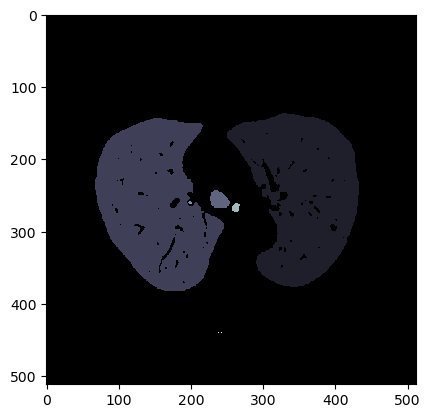

In [26]:
# plt.imshow(img_tuple[10][0][0], cmap=plt.cm.bone)

print(file_list[4])
print(np.min(np.load(file_list[1])))
plt.imshow(img_tuple[1][0][3], cmap=plt.cm.bone)

# for ((im, label_image, binary, areas), filename) in img_tuple:
#     filename = filename.split('/')[-1]
#     Image.fromarray(im).save(f'{luna_path}overlay/{filename}.png')
#     Image.fromarray(label_image).save(f'{luna_path}label_image/{filename}.png')
#     Image.fromarray(binary).save(f'{luna_path}binary_image/{filename}.png')
#     Image.fromarray(areas).save(f'{luna_path}area_image/{filename}.png')